In [1]:
import numpy as np
import csv
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib

import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset_odn = datasets.C100Dataset('./dataset/data/cifar100.csv')
[tr_x, tr_y, ts_x, ts_y] = dataset_odn.getDataset()

In [3]:
len(tr_x), len(ts_x), len(set(tr_y))

(50000, 10000, 100)

turtle


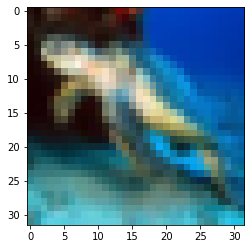

In [4]:
im_dir = './dataset/'
plt.imshow(img.imread(im_dir+tr_x[99]))
print(tr_y[99])

In [5]:
label = set(tr_y)
label = np.array(list(label))
label

array(['pine_tree', 'lion', 'orange', 'turtle', 'cattle', 'possum',
       'palm_tree', 'snail', 'dolphin', 'tank', 'table', 'squirrel',
       'crocodile', 'bus', 'bee', 'crab', 'otter', 'man', 'baby', 'cup',
       'rabbit', 'willow_tree', 'sweet_pepper', 'camel', 'lobster',
       'bowl', 'bear', 'girl', 'whale', 'lamp', 'skyscraper', 'shark',
       'aquarium_fish', 'streetcar', 'tulip', 'wolf', 'mouse', 'shrew',
       'bicycle', 'snake', 'sunflower', 'couch', 'television',
       'chimpanzee', 'poppy', 'worm', 'oak_tree', 'bridge', 'trout',
       'beaver', 'lawn_mower', 'mountain', 'plate', 'flatfish', 'apple',
       'rocket', 'ray', 'porcupine', 'bed', 'butterfly', 'seal',
       'motorcycle', 'tractor', 'skunk', 'maple_tree', 'tiger',
       'caterpillar', 'keyboard', 'clock', 'lizard', 'can', 'telephone',
       'rose', 'cloud', 'wardrobe', 'orchid', 'hamster', 'kangaroo',
       'elephant', 'pear', 'bottle', 'plain', 'fox', 'beetle', 'woman',
       'boy', 'cockroach', 'spi

In [6]:
def tr_val(x_, y_):
    mask = np.ones(len(x_))
    mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    y_tr, y_vl = y_[mask==1], y_[mask==0]
    return x_tr, x_vl, y_tr, y_vl
def batch_div(x_, y_, num):
    x_b, y_b = [], []
    mask = np.tile(np.arange(int(len(x_)/num)), num)
    np.random.shuffle(mask)
    for i in range (int(len(x_)/num)):
        x_b.append(x_[mask==i])
        y_b.append(y_[mask==i])
    return int(len(x_)/num), x_b, y_b

# CNN

In [7]:
trainx = np.array([img.imread(im_dir+u).T for i,u in enumerate(tr_x)])
trainy = np.zeros([len(tr_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(tr_y):
        if v==u: trainy[j][i] = 1
            
testx = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x)])
testy = np.zeros([len(ts_y), 100], dtype='int32')
for i,u in enumerate(label):
    for j,v in enumerate(ts_y):
        if v==u: testy[j][i] = 1
trainx, testx = torch.FloatTensor(trainx), torch.FloatTensor(testx)
trainy, testy = torch.FloatTensor(trainy), torch.FloatTensor(testy)

In [8]:
import torchvision
import torchvision.transforms as transforms

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.C1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.C2 = nn.Conv2d(6, 16, 4)
        self.W1 = nn.Linear(16*25, 100)
        self.W2 = nn.Linear(100, 100)
        self.S = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.C1(x)))
        x = self.pool(F.relu(self.C2(x)))
        x = x.view(-1, 16*25)
        x = self.S(self.W2(F.relu(self.W1(x))))
        return x
    
def loss1(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
    return F.binary_cross_entropy(output, y)+regular
def loss2(output, y):
    #regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
    return F.binary_cross_entropy(output, y)

def accuracy(output, y):
    return torch.sum(torch.argmax(output, axis=1)==torch.argmax(y, axis=1))

In [10]:
reg = 0
model = CNN()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 25
x_tr, x_vl, y_tr, y_vl = tr_val(trainx, trainy)
tr_loss, vl_loss = np.zeros(n_epochs, dtype='float64'), np.zeros(n_epochs, dtype='float64')
tr_accy, vl_accy, ts_accy = np.zeros_like(tr_loss), np.zeros_like(tr_loss), np.zeros_like(tr_loss)

for epoch in range(n_epochs):
    losst = 0.
    accyt = 0
    batchnum, x_tr_b, y_tr_b = batch_div(x_tr, y_tr, 100)
    for i in range (batchnum):
        output = model.forward(x_tr_b[i])
        loss = loss2(output, y_tr_b[i])
        accy = accuracy(output, y_tr_b[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losst += loss.item()
        accyt += accy
    
    output2 = model.forward(x_vl)
    tr_loss[epoch] = losst
    tr_accy[epoch] = accyt
    vl_loss[epoch] = loss2(output2, y_vl).item()
    vl_accy[epoch] = accuracy(output2, y_vl)
    ts_accy[epoch] = accuracy(model.forward(testx), testy)
    
    print("epoch:", epoch, "*test loss:", losst, "*val loss:", vl_loss[epoch], \
          "*tr/vl/ts accuracy:", tr_accy[epoch]/400, vl_accy[epoch]/100, ts_accy[epoch]/100)

epoch: 0 *test loss: 32.207499757409096 *val loss: 0.056038931012153625 *tr/vl/ts accuracy: 1.3325 1.98 1.81
epoch: 1 *test loss: 21.4877061098814 *val loss: 0.051831215620040894 *tr/vl/ts accuracy: 4.495 5.82 5.95
epoch: 2 *test loss: 20.32963677868247 *val loss: 0.04999823123216629 *tr/vl/ts accuracy: 7.955 9.13 8.9
epoch: 3 *test loss: 19.78544982522726 *val loss: 0.04884398356080055 *tr/vl/ts accuracy: 9.9525 10.95 10.91
epoch: 4 *test loss: 19.382645711302757 *val loss: 0.04820786044001579 *tr/vl/ts accuracy: 11.63 11.76 11.86
epoch: 5 *test loss: 19.055275388062 *val loss: 0.047204021364450455 *tr/vl/ts accuracy: 12.8375 13.61 13.39
epoch: 6 *test loss: 18.771547198295593 *val loss: 0.047186773270368576 *tr/vl/ts accuracy: 14.1375 13.71 13.76
epoch: 7 *test loss: 18.483314529061317 *val loss: 0.046011827886104584 *tr/vl/ts accuracy: 15.245 15.63 15.59
epoch: 8 *test loss: 18.208460930734873 *val loss: 0.04536965861916542 *tr/vl/ts accuracy: 16.3675 17.23 16.82
epoch: 9 *test loss

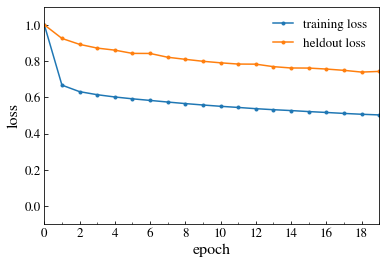

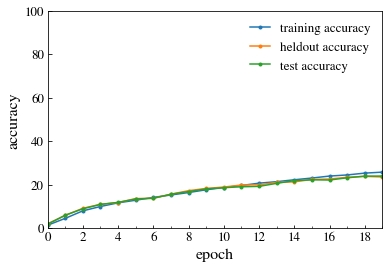

In [14]:
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : False ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : False ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

plt.plot(tr_loss/tr_loss[0], '.-', label='training loss')
plt.plot(vl_loss/vl_loss[0], '.-', label='heldout loss')
plt.legend()
plt.ylim(-0.1, 1.1)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('cnn_loss.png')
plt.show()


plt.plot(tr_accy/400, '.-', label='training accuracy')
plt.plot(vl_accy/100, '.-', label='heldout accuracy')
plt.plot(ts_accy/100, '.-', label='test accuracy')
plt.ylim(0, 100)
plt.xlim(0, 19)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('cnn_acc.png')
plt.show()

In [12]:
def pred_img(num):
    im_dir = './dataset/'
    plt.imshow(img.imread(im_dir+ts_x[num]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x[num:num+1])])
    test_x = torch.FloatTensor(test_x)
    print("real:", ts_y[num], "pred:", label[model.forward(test_x).argmax(axis=1)])
def correct_img():
    correct_ind = []
    im_dir = './dataset/'
    for i in range (10000):
        test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
        test_x = torch.FloatTensor(test_x)
        test_y = ts_y[i]
        output = model.forward(test_x)
        if torch.argmax(output, axis=1)==torch.argmax(testy[i]):
            correct_ind.append(i)
    return correct_ind
             
correct_ind = correct_img()

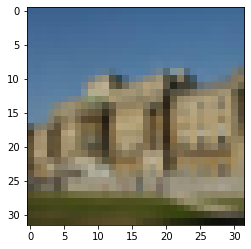

real: castle pred: castle


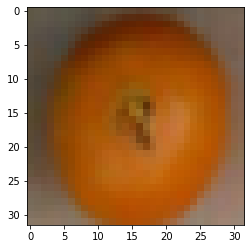

real: orange pred: orange


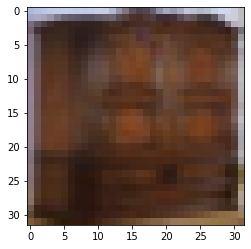

real: wardrobe pred: wardrobe


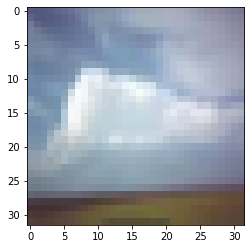

real: cloud pred: cloud


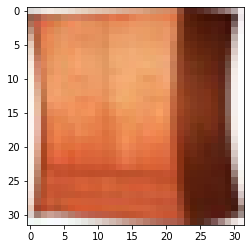

real: wardrobe pred: wardrobe


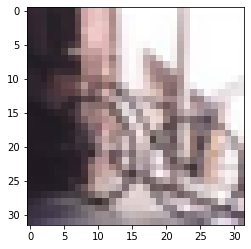

real: bicycle pred: bicycle


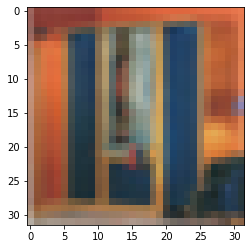

real: wardrobe pred: wardrobe


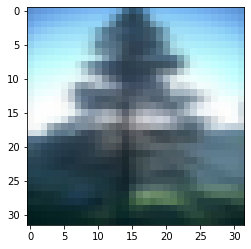

real: pine_tree pred: pine_tree


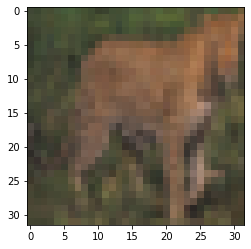

real: leopard pred: leopard


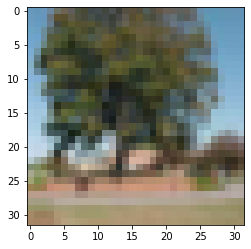

real: oak_tree pred: oak_tree


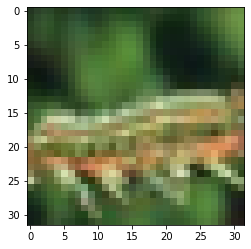

real: caterpillar pred: caterpillar


In [14]:
n=0
num=10
np.random.shuffle(correct_ind)
for i in correct_ind:
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    test_y = ts_y[i]
    print("real:", test_y, "pred:", label[model.forward(test_x).argmax(axis=1)])
    n+=1
    if n>num: break

In [16]:
a = []
b = []
for i in range(10000):
    #plt.imshow(img.imread(im_dir+ts_x[i]))
    #plt.show()
    a.append(ts_x[i])
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    b.append(label[model.forward(test_x).argmax(axis=1)])
a = np.array(a)
b = np.array(b)
np.savetxt('cifar100pred_cnn.csv', np.array([a, b]).T, fmt='%s', delimiter=',',\
          header='id,category')